# Energy Economics, Spring 2019
## Morten Rasmussen, Christian Sørensen

## Preamble

In [25]:
import csv
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
from datetime import datetime
import xlrd
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
import seaborn as sns; sns.set()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 


## Data gathering and cleaning

In [20]:
#%% Data gathering and cleaning

# price_data = []
# for x in range(2016, 2019):
#     url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/elspot-prices_'+str(x)+'_hourly_dkk.xls'
#     urlretrieve(url,'elspot-prices_'+str(x)+'_hourly_dkk.xls')
#     filename='elspot-prices_'+str(x)+'_hourly_dkk.XLS'
#     data= pd.read_html(filename)
#     data=pd.DataFrame(data[0])
#     data=data.iloc[:,[0,1,8,9]]
#     data.columns=['date','time', 'DK_vest_pris', 'DK_øst_pris']
#     price_data.append(data)

# price_data = pd.concat(price_data, axis=0)

# Retrieve forecast data from nordpoolgroup.com. 
forecast_data = []
for x in range(2013, 2014):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk-prognosis_'+str(x)+'_hourly.xls')
    filename='wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_forecast', 'DK_øst_forecast']
    forecast_data.append(data)

forecast_data = pd.concat(forecast_data, axis=0)

# Retrieve production data from nordpoolgroup.com
production_data = []
for x in range(2013, 2014):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk_'+str(x)+'_hourly.xls')
    filename='wind-power-dk_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_production', 'DK_øst_production']
    production_data.append(data)

production_data = pd.concat(production_data, axis=0)







In [21]:
# Merge forecast and production data, and extract year, month, weekday, hour:
data=pd.merge(forecast_data, production_data, on=['date','time'], indicator = True)
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date

data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['year'] = pd.DatetimeIndex(data['date']).year
data['weekday'] = pd.DatetimeIndex(data['date']).weekday
data['hour']=data['time'].str.slice(0, 2)
data.hour = data.hour.astype(int)

# Calculate forecasting error in each price area
data['forecasting_error_øst']=data['DK_øst_production'] - data['DK_øst_forecast']
data['forecasting_error_vest']=data['DK_vest_production'] - data['DK_vest_forecast']

# Inspect data
data[data["_merge"] != "both"]





,date,time,DK_vest_forecast,DK_øst_forecast,DK_vest_production,DK_øst_production,_merge,month,day,year,weekday,hour,forecasting_error_øst,forecasting_error_vest


In [22]:
data.to_pickle("data_nordpool.pkl")

In [38]:
data = pd.read_pickle("data_nordpool.pkl")
data.drop(labels = "_merge", axis = 1, inplace = True)
data.head()

,date,time,DK_vest_forecast,DK_øst_forecast,DK_vest_production,DK_øst_production,month,day,year,weekday,hour,forecasting_error_øst,forecasting_error_vest
0,2013-01-01,00 - 01,1968.0,830.0,1941.0,893.0,1,1,2013,1,0,63.0,-27.0
1,2013-01-01,01 - 02,1599.0,818.0,1446.0,885.0,1,1,2013,1,1,67.0,-153.0
2,2013-01-01,02 - 03,1238.0,798.0,1041.0,850.0,1,1,2013,1,2,52.0,-197.0
3,2013-01-01,03 - 04,941.0,765.0,867.0,818.0,1,1,2013,1,3,53.0,-74.0
4,2013-01-01,04 - 05,709.0,718.0,687.0,755.0,1,1,2013,1,4,37.0,-22.0


In [39]:
# Split data sets according to price area
data_vest=data[['date','hour','day','weekday','year', 'month', 'DK_vest_production','DK_vest_forecast','forecasting_error_vest'] ]
data_øst=data[['date','hour','day','weekday','year','month', 'DK_øst_production','DK_øst_forecast','forecasting_error_øst'] ]

In [40]:
# Load market data from energidataservice. Note, that this reads from a local file .xlsx file. 
# Key variables are Elbas price (min, max, avg), spot prices and date (hourly)
prices= pd.read_excel("Nordpool_Market_Data.xlsx")
prices['date'] = pd.to_datetime(prices['HourDK'])
prices['hour'] = pd.DatetimeIndex(prices['date']).hour
prices['date'] = prices['date'].dt.date
prices['price_diff'] = prices["ElbasAveragePriceDKK"]-prices["SpotPriceDKK"]

# Construct dataset pertaining to price area 1 (west)
prices_vest=prices[prices['PriceArea']=='DK1']

# Merge price-data with wind-data: 
final_vest=pd.merge(prices_vest, data_vest, on=['date','hour'], indicator = True)


In [18]:
final_vest["_merge"].describe()

count     8766
unique       1
top       both
freq      8766
Name: _merge, dtype: object

In [60]:

final_vest['ElbasAveragePriceDKK']=final_vest['ElbasAveragePriceDKK'].fillna(0)
final_vest['ElbasAveragePriceDKK'] = pd.to_numeric(final_vest['ElbasAveragePriceDKK'])
final_vest["price_diff"] = final_vest["ElbasAveragePriceDKK"]-final_vest["SpotPriceDKK"]
final_vest.loc[final_vest["ElbasAveragePriceDKK"] == 0, "price_diff"] = 0

final_vest["outlier"] = 0
final_vest.loc[final_vest["SpotPriceDKK"] > 1000, "outlier"] = 1


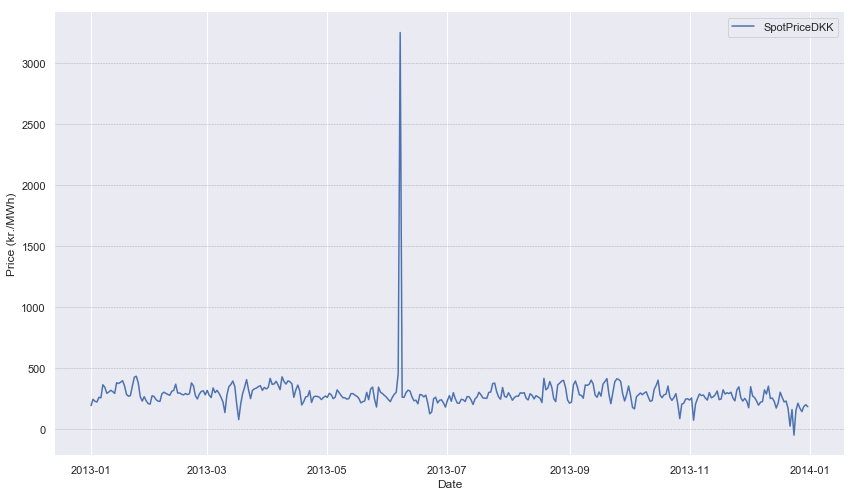

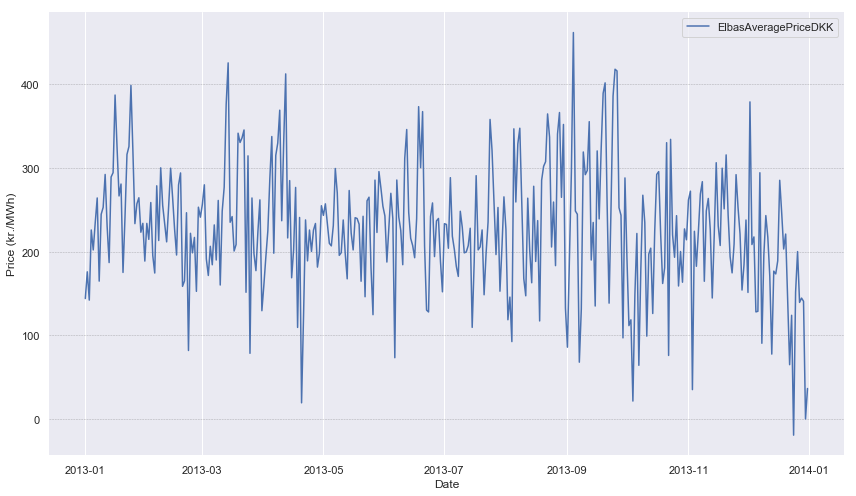

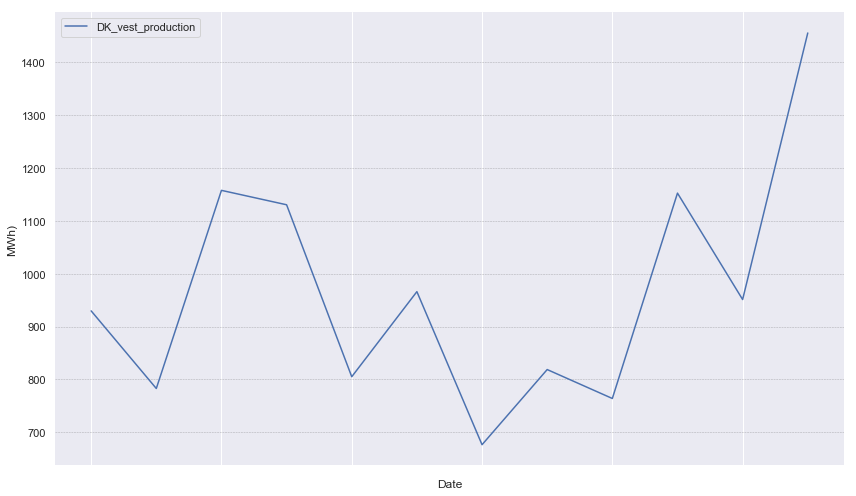

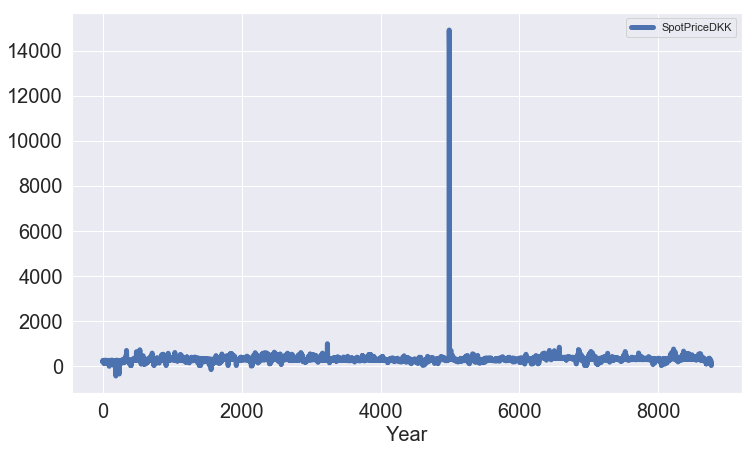

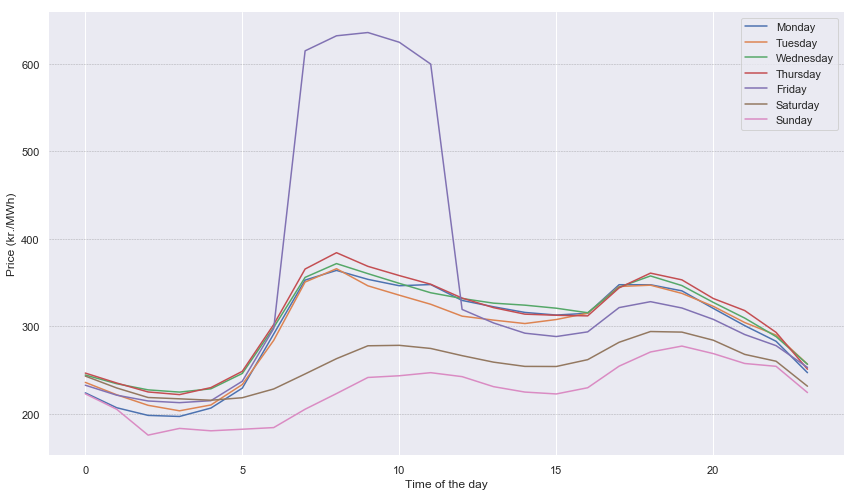

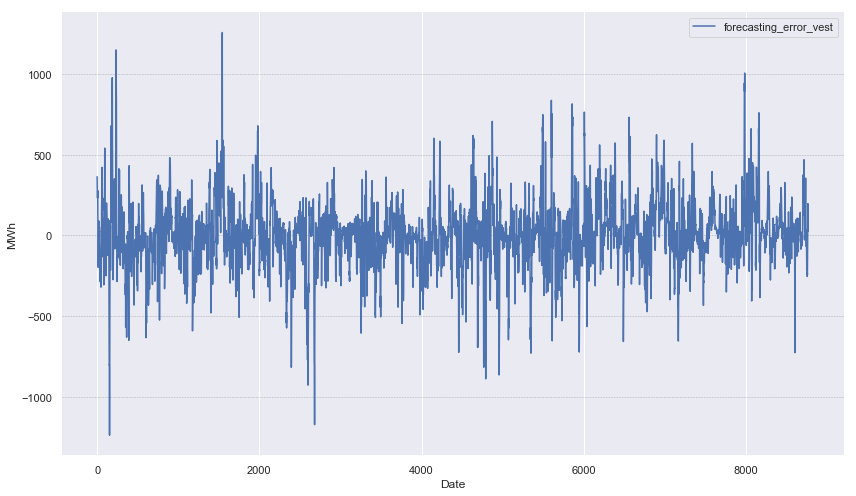

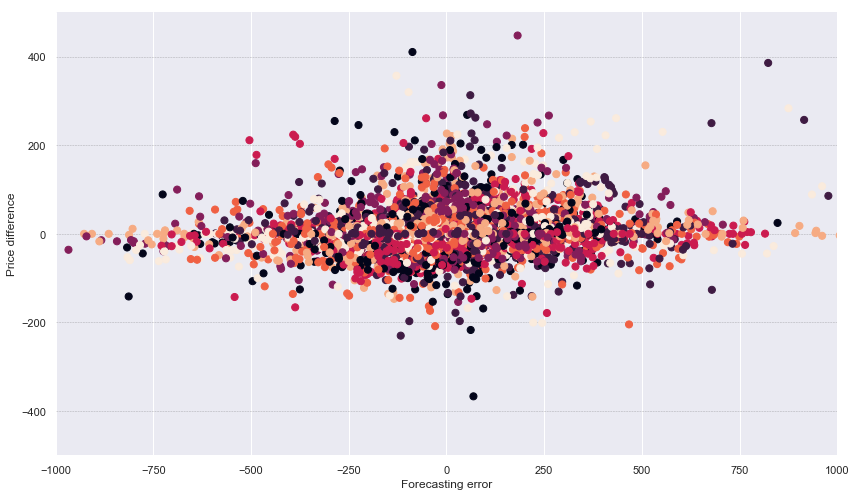

In [24]:
#%% Data description
#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['SpotPriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['ElbasAveragePriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in wind power production, monthly
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['year','month']).mean()[['DK_vest_production']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()


#Over 24 hours
final_vest[['SpotPriceDKK']].plot(figsize=(12,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['hour','weekday']).mean()['SpotPriceDKK'].unstack().plot(ax=ax)
plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Time of the day')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Prediction errors
fig, ax = plt.subplots(figsize=(12,7))
final_vest[['forecasting_error_vest']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(12,7))
plt.scatter(final_vest.forecasting_error_vest, final_vest.price_diff, s=50, c=final_vest.weekday)
plt.xlabel('Forecasting error')
plt.ylabel('Price difference')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([-500,500])
ax.set_xlim([-1000,1000])
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)

fig.tight_layout()

plt.show()



In [56]:
final_vest[final_vest["SpotPriceDKK"]>1000]

,HourUTC,HourDK,PriceArea,SpotPurchase,SpotSale,SpotPriceDKK,ElbasAveragePriceDKK,ElbasMaxPriceDKK,ElbasMinPriceDKK,SpotPriceEUR,...,hour,price_diff,day,weekday,year,month,DK_vest_production,DK_vest_forecast,forecasting_error_vest,_merge
4987,2013-06-07 09:00:00,2013-06-07 11:00:00,DK1,1697.9,997.9,14175.4,599.36,1192.93,298.23,1901.36,...,11,-13576.04,7,4,2013,6,183.0,220.0,37.0,both
4988,2013-06-07 08:00:00,2013-06-07 10:00:00,DK1,1695.7,995.7,14910.8,628.35,1192.93,298.23,2000.00,...,10,-14282.45,7,4,2013,6,204.0,261.0,57.0,both
4989,2013-06-07 07:00:00,2013-06-07 09:00:00,DK1,1705.0,1005.0,14910.8,632.05,1192.93,313.14,2000.00,...,9,-14278.75,7,4,2013,6,239.0,304.0,65.0,both
4990,2013-06-07 06:00:00,2013-06-07 08:00:00,DK1,1714.4,1014.4,14175.7,648.49,1192.93,342.97,1901.40,...,8,-13527.21,7,4,2013,6,309.0,349.0,40.0,both
4991,2013-06-07 05:00:00,2013-06-07 07:00:00,DK1,1693.5,993.5,14175.1,590.68,1192.93,313.14,1901.32,...,7,-13584.42,7,4,2013,6,370.0,399.0,29.0,both


In [42]:
final_vest.columns

Index(['HourUTC', 'HourDK', 'PriceArea', 'SpotPurchase', 'SpotSale',
       'SpotPriceDKK', 'ElbasAveragePriceDKK', 'ElbasMaxPriceDKK',
       'ElbasMinPriceDKK', 'SpotPriceEUR', 'ElbasAveragePriceEUR',
       'ElbasMaxPriceEUR', 'ElbasMinPriceEUR', 'date', 'hour', 'price_diff',
       'day', 'weekday', 'year', 'month', 'DK_vest_production',
       'DK_vest_forecast', 'forecasting_error_vest', '_merge'],
      dtype='object')

In [29]:
final_vest.head(5)

,HourUTC,HourDK,PriceArea,SpotPurchase,SpotSale,SpotPriceDKK,ElbasAveragePriceDKK,ElbasMaxPriceDKK,ElbasMinPriceDKK,SpotPriceEUR,...,hour,price_diff,day,weekday,year,month,DK_vest_production,DK_vest_forecast,forecasting_error_vest,_merge
0,2013-12-31 22:00:00,2013-12-31 23:00:00,DK1,829.7,2476.6,185.80,0.00,NaN,NaN,24.91,...,23,0.00,31,1,2013,12,1702.0,2066.0,364.0,both
1,2013-12-31 21:00:00,2013-12-31 22:00:00,DK1,876.5,2402.0,214.60,106.18,108.17,105.19,28.77,...,22,-108.42,31,1,2013,12,1809.0,2105.0,296.0,both
2,2013-12-31 20:00:00,2013-12-31 21:00:00,DK1,990.8,2779.3,149.63,0.00,NaN,NaN,20.06,...,21,0.00,31,1,2013,12,1817.0,2107.0,290.0,both
3,2013-12-31 19:00:00,2013-12-31 20:00:00,DK1,1055.7,2998.7,209.97,0.00,NaN,NaN,28.15,...,20,0.00,31,1,2013,12,1822.0,2102.0,280.0,both
4,2013-12-31 18:00:00,2013-12-31 19:00:00,DK1,1677.9,2490.4,226.01,233.59,253.65,216.35,30.30,...,19,7.58,31,1,2013,12,1824.0,2072.0,248.0,both


## Estimation 
We assume the following DGP: 
$$ \Delta P_t = \alpha + \beta \Delta W_t + \epsilon_t, \quad \epsilon_t \sim $$
Where $\Delta P_t =  \texttt{Elbas}_t - \texttt{Spot}_t$, and $\Delta W_t = \texttt{Production} - \texttt{Forecast}$ 

In [27]:
# Estimation 
basic_model = ols("price_diff ~ forecasting_error_vest", data = final_vest).fit()
print(basic_model.summary())

Next, we include dummies to account for calendar effects (hour, weekday and month): 
$$ \Delta P_t = \alpha + \beta \Delta W_t + \texttt{hour}_t + \texttt{weekday}_t+\texttt{month}_t$$

In [43]:
final_vest["hour"] = final_vest["hour"].apply(str)

In [57]:
final_vest["hour"] = final_vest["hour"].astype(str).astype(int)

In [58]:
final_vest.dtypes

HourUTC                   datetime64[ns]
HourDK                    datetime64[ns]
PriceArea                         object
SpotPurchase                     float64
SpotSale                         float64
SpotPriceDKK                     float64
ElbasAveragePriceDKK             float64
ElbasMaxPriceDKK                 float64
ElbasMinPriceDKK                 float64
SpotPriceEUR                     float64
ElbasAveragePriceEUR             float64
ElbasMaxPriceEUR                 float64
ElbasMinPriceEUR                 float64
date                              object
hour                               int32
price_diff                       float64
day                                int64
weekday                            int64
year                               int64
month                              int64
DK_vest_production               float64
DK_vest_forecast                 float64
forecasting_error_vest           float64
_merge                          category
dtype: object

In [66]:
# Estimation: Calendar-dummies
calen_model = ols("price_diff ~ forecasting_error_vest + C(month) + C(weekday) + C(hour) + outlier"
                  , data = final_vest).fit()
print(calen_model.summary())


                            OLS Regression Results                            
Dep. Variable:             price_diff   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.186e+04
Date:                Fri, 15 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:24:59   Log-Likelihood:                -45562.
No. Observations:                8765   AIC:                         9.121e+04
Df Residuals:                    8722   BIC:                         9.151e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
fig = sm.graphics.plot_partregress("price_diff","forecasting_error_vest", ["forecasting_error_vest", "C(month)"," C(weekday)"," C(hour)"," outlier"], data=final_vest, ax=ax)


In [ ]:
# Andele af production
# Autocorrelation